E10.project_Shallow_DOF
===
---

일반 사진에서 피사체에 초점을 맞추어 Shallow_DOF 처리를 해보자! 

![ss](https://user-images.githubusercontent.com/70703320/108526176-2ad3dd00-7314-11eb-9816-4ce14c59d634.jpg)
[이미지 출처](https://www.adobe.com/sea/creativecloud/photography/discover/shallow-depth-of-field.html)



## 1. 차, 사람, 고양이 사진에 대한 Shallow_DOF 처리

#### 라이브러리

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹에서 데이터를 다운 받을 시 사용

from matplotlib import pyplot as plt
import tensorflow as tf

#### 이미지 불러오기

In [2]:
import os
son_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Son_Car.jpg' 
son_img_orig = cv2.imread(son_path)
jisu_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Jisu.jpg' 
jisu_img_orig = cv2.imread(jisu_path)
rb_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Russian_Blue.jpg' 
rb_img_orig = cv2.imread(rb_path)


print ('손흥민과 S90 : {}'.format(son_img_orig.shape), '지수: {}'.format(jisu_img_orig.shape), '러시안 블루: {}'.format(rb_img_orig.shape), sep ='\n')

손흥민과 S90 : (393, 600, 3)
지수: (862, 800, 3)
러시안 블루: (576, 1024, 3)


#### 구글에서 제공하는 모델 구조 그대로 가져와 DeepLabModel 클래스 만들기

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 구글에서 만든 DeepLab 코드 다운로드 하기

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj63/aiffel/human_segmentation/models
model loaded successfully!


#### 이미지를 resize

In [5]:
son_img_resized, son_seg_map = MODEL.run(son_img_orig)
jisu_img_resized, jisu_seg_map = MODEL.run(jisu_img_orig)
rb_img_resized, rb_seg_map = MODEL.run(rb_img_orig)

print ('왼쪽부터       (원본사이즈), (리사이즈), (라벨인덱스)', '---------------------------------------------------',
       '손흥민과 S90 :{},{},{}'.format(son_img_orig.shape, son_img_resized.shape, son_seg_map.max()),
       '지수         :{},{},{}'.format(jisu_img_orig.shape, jisu_img_resized.shape, jisu_seg_map.max()),
       '러시안 블루  :{},{},{}'.format(rb_img_orig.shape, rb_img_resized.shape, rb_seg_map.max()), sep='\n')

왼쪽부터       (원본사이즈), (리사이즈), (라벨인덱스)
---------------------------------------------------
손흥민과 S90 :(393, 600, 3),(336, 513, 3),15
지수         :(862, 800, 3),(513, 476, 3),15
러시안 블루  :(576, 1024, 3),(288, 513, 3),8


#### DeepLab 에서 제공하는 라벨 종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### 시맨틱 세그멘테이션

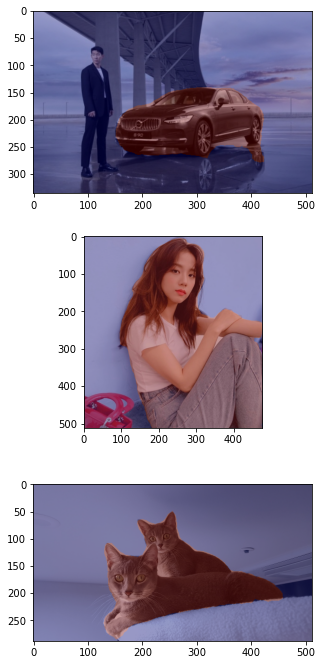

In [7]:
# son
son_img_show = son_img_resized.copy()
son_seg_map = np.where(son_seg_map == 7, 7, 0) 
son_img_mask = son_seg_map * (255/son_seg_map.max()) 
son_img_mask = son_img_mask.astype(np.uint8)
son_color_mask = cv2.applyColorMap(son_img_mask, cv2.COLORMAP_JET)
son_img_show = cv2.addWeighted(son_img_show, 0.6, son_color_mask, 0.35, 0.0)

# jisu
jisu_img_show = jisu_img_resized.copy()
jisu_seg_map = np.where(jisu_seg_map == 15, 15, 0) 
jisu_img_mask = jisu_seg_map * (255/jisu_seg_map.max()) 
jisu_img_mask = jisu_img_mask.astype(np.uint8)
jisu_color_mask = cv2.applyColorMap(jisu_img_mask, cv2.COLORMAP_JET)
jisu_img_show = cv2.addWeighted(jisu_img_show, 0.6, jisu_color_mask, 0.35, 0.0)

# rb
rb_img_show = rb_img_resized.copy()
rb_seg_map = np.where(rb_seg_map == 8, 8, 0) 
rb_img_mask = rb_seg_map * (255/rb_seg_map.max())
rb_img_mask = rb_img_mask.astype(np.uint8)
rb_color_mask = cv2.applyColorMap(rb_img_mask, cv2.COLORMAP_JET)
rb_img_show = cv2.addWeighted(rb_img_show, 0.6, rb_color_mask, 0.35, 0.0)



# figsize
plt.figure(figsize=(5, 12))



# son
ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(son_img_show, cv2.COLOR_BGR2RGB))

# jisu
ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(jisu_img_show, cv2.COLOR_BGR2RGB))

# rb
ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(rb_img_show, cv2.COLOR_BGR2RGB))
plt.show()


#### 원본사이즈와 리사이즈 비교해보기

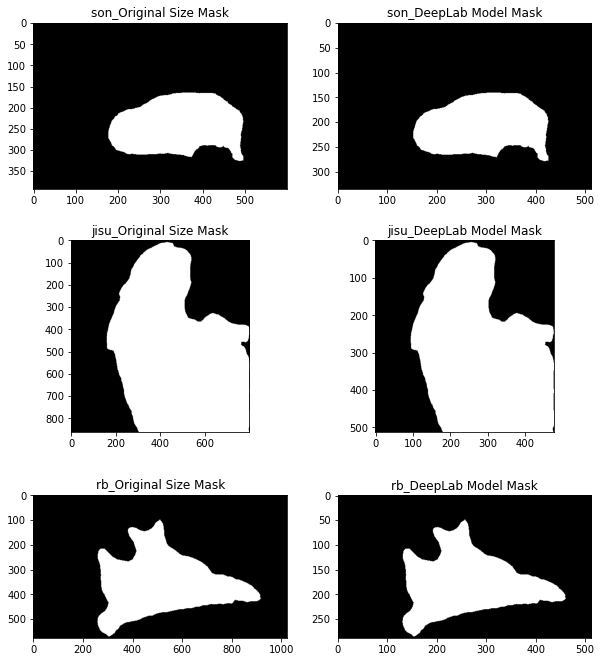

In [8]:
# son
son_img_mask_up = cv2.resize(son_img_mask, son_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, son_img_mask_up = cv2.threshold(son_img_mask_up, 128, 255, cv2.THRESH_BINARY)
# jisu
jisu_img_mask_up = cv2.resize(jisu_img_mask, jisu_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, jisu_img_mask_up = cv2.threshold(jisu_img_mask_up, 128, 255, cv2.THRESH_BINARY)
# rb
rb_img_mask_up = cv2.resize(rb_img_mask, rb_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, rb_img_mask_up = cv2.threshold(rb_img_mask_up, 128, 255, cv2.THRESH_BINARY)


# figsize
plt.figure(figsize=(10, 12))


# son
ax = plt.subplot(3,2,1)
plt.imshow(son_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('son_Original Size Mask')

ax = plt.subplot(3,2,2)
plt.imshow(son_img_mask, cmap=plt.cm.binary_r)
ax.set_title('son_DeepLab Model Mask')

# jisu
ax = plt.subplot(3,2,3)
plt.imshow(jisu_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('jisu_Original Size Mask')

ax = plt.subplot(3,2,4)
plt.imshow(jisu_img_mask, cmap=plt.cm.binary_r)
ax.set_title('jisu_DeepLab Model Mask')

# rb
ax = plt.subplot(3,2,5)
plt.imshow(rb_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('rb_Original Size Mask')

ax = plt.subplot(3,2,6)
plt.imshow(rb_img_mask, cmap=plt.cm.binary_r)
ax.set_title('rb_DeepLab Model Mask')



plt.show()

#### 세그멘테이션 마스크를 이용해 배경만 추출하기

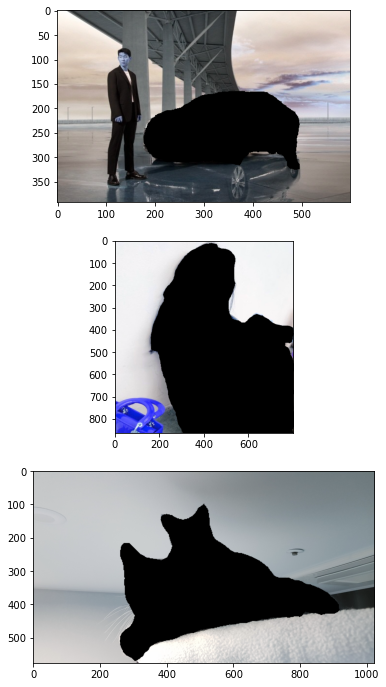

In [9]:
# son
son_img_mask_color = cv2.cvtColor(son_img_mask_up, cv2.COLOR_GRAY2BGR)
son_img_bg_mask = cv2.bitwise_not(son_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
son_img_bg = cv2.bitwise_and(son_img_orig, son_img_bg_mask)  # 배경만 있는 영상 얻기

# jisu
jisu_img_mask_color = cv2.cvtColor(jisu_img_mask_up, cv2.COLOR_GRAY2BGR)
jisu_img_bg_mask = cv2.bitwise_not(jisu_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
jisu_img_bg = cv2.bitwise_and(jisu_img_orig, jisu_img_bg_mask)  # 배경만 있는 영상 얻기

# rb
rb_img_mask_color = cv2.cvtColor(rb_img_mask_up, cv2.COLOR_GRAY2BGR)
rb_img_bg_mask = cv2.bitwise_not(rb_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
rb_img_bg = cv2.bitwise_and(rb_img_orig, rb_img_bg_mask)  # 배경만 있는 영상 얻기


# figsize
plt.figure(figsize=(10, 12))


# son
ax = plt.subplot(3,1,1)
plt.imshow(son_img_bg)

# jisu
ax = plt.subplot(3,1,2)
plt.imshow(jisu_img_bg)

# rb
ax = plt.subplot(3,1,3)
plt.imshow(rb_img_bg)


plt.show()

#### 이미지 blur 처리하기

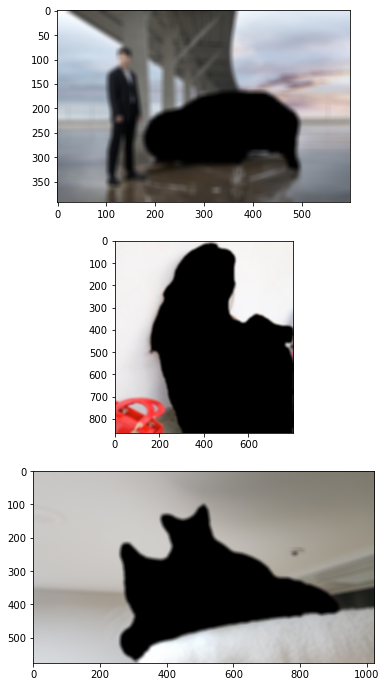

In [10]:
# figsize
plt.figure(figsize=(10, 12))


# son
ax = plt.subplot(3,1,1)
son_img_bg_blur = cv2.blur(son_img_bg, (13,13))
plt.imshow(cv2.cvtColor(son_img_bg_blur, cv2.COLOR_BGR2RGB))

# jisu
ax = plt.subplot(3,1,2)
jisu_img_bg_blur = cv2.blur(jisu_img_bg, (13,13))
plt.imshow(cv2.cvtColor(jisu_img_bg_blur, cv2.COLOR_BGR2RGB))

# rb
ax = plt.subplot(3,1,3)
rb_img_bg_blur = cv2.blur(rb_img_bg, (13,13))
plt.imshow(cv2.cvtColor(rb_img_bg_blur, cv2.COLOR_BGR2RGB))


plt.show()

#### 배경이미지와 사람이미지 합성하기

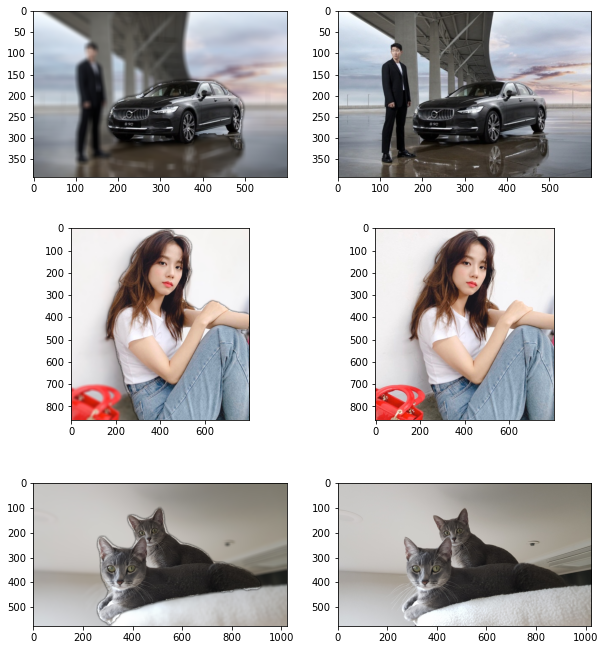

In [11]:
# figsize
plt.figure(figsize=(10, 12))


# son
ax = plt.subplot(3,2,1)
son_img_concat = np.where(son_img_mask_color==255, son_img_orig, son_img_bg_blur)
plt.imshow(cv2.cvtColor(son_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(3,2,2)
plt.imshow(cv2.cvtColor(son_img_orig, cv2.COLOR_BGR2RGB))


# jisu
ax = plt.subplot(3,2,3)
jisu_img_concat = np.where(jisu_img_mask_color==255, jisu_img_orig, jisu_img_bg_blur)
plt.imshow(cv2.cvtColor(jisu_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(3,2,4)
plt.imshow(cv2.cvtColor(jisu_img_orig, cv2.COLOR_BGR2RGB))


# rb
ax = plt.subplot(3,2,5)
rb_img_concat = np.where(rb_img_mask_color==255, rb_img_orig, rb_img_bg_blur)
plt.imshow(cv2.cvtColor(rb_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(3,2,6)
plt.imshow(cv2.cvtColor(rb_img_orig, cv2.COLOR_BGR2RGB))



plt.show()

## 2. 배경사진을 다른 것으로 바꿔주기

#### 데이터 불러오기

In [12]:
br_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me.jpg' 
br_img_orig = cv2.imread(br_path)
bk_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/magma.jpeg' 
bk_img_orig = cv2.imread(bk_path)

print ('나: {}'.format(br_img_orig.shape), '배경: {}'.format(bk_img_orig.shape),sep ='\n')

나: (2316, 3088, 3)
배경: (400, 500, 3)


#### 리사이즈 확인하기

In [13]:
br_img_resized, br_seg_map = MODEL.run(br_img_orig)
bk_img_resized = cv2.resize(bk_img_orig, (3088, 2316))

print ('왼쪽부터       (원본사이즈), (리사이즈), (라벨인덱스)', '---------------------------------------------------',
       '나   :{},{},{}'.format(br_img_orig.shape, br_img_resized.shape, br_seg_map.max()),
       '배경 :{},{}'.format(bk_img_orig.shape, bk_img_resized.shape),sep='\n')

왼쪽부터       (원본사이즈), (리사이즈), (라벨인덱스)
---------------------------------------------------
나   :(2316, 3088, 3),(384, 513, 3),15
배경 :(400, 500, 3),(2316, 3088, 3)


#### 배경합성 사진과 원본 사진 비교

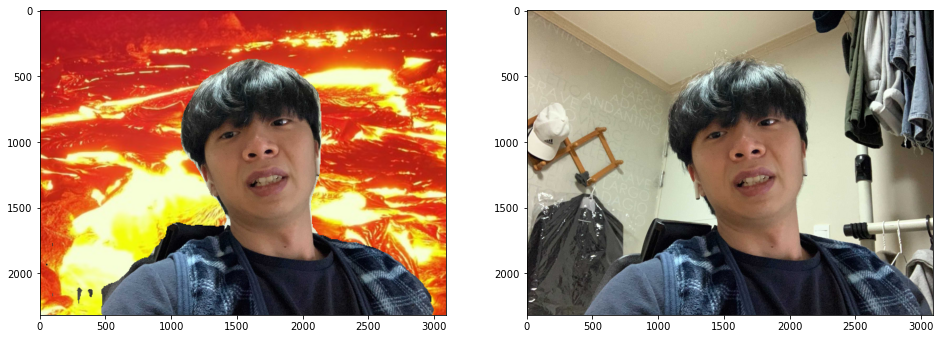

In [14]:
# 시맨틱 세그멘테이션
br_img_show = br_img_resized.copy()
br_seg_map = np.where(br_seg_map == 15, 15, 0) 
br_img_mask = br_seg_map * (255/br_seg_map.max()) 
br_img_mask = br_img_mask.astype(np.uint8)
br_color_mask = cv2.applyColorMap(br_img_mask, cv2.COLORMAP_JET)
br_img_show = cv2.addWeighted(br_img_show, 0.6, br_color_mask, 0.35, 0.0)

# 마스크업
br_img_mask_up = cv2.resize(br_img_mask, br_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 떼어놓기
br_img_mask_color = cv2.cvtColor(br_img_mask_up, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(16, 6))

# 합성과 원본 비교
ax = plt.subplot(1,2,1)
br_img_concat = np.where(br_img_mask_color==255, br_img_orig, bk_img_resized)
plt.imshow(cv2.cvtColor(br_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(br_img_orig, cv2.COLOR_BGR2RGB))

plt.show()


> 합성사진 안 왼쪽 어깨 부분이 제대로 분리되지 않은 것을 확인할 수 있다. 그렇다면 어떻게 제대로 분리해낼 수 있을까?

## 3. 이상한 위치의 사진 해결하는 방안 제시하기

#### 문제의 원인을 생각해보자
    - 내가 생각한 문제의 원인은 피사체를 배경에서 분리해내지 못한다는 것이고 이는 피사체와 배경간의 거리가 2D로 인식하여 같다고 생각하고 사람의 형체만 인식하여 분리하는 시스템이기 때문이다. 이를 해결하기 위해서는 피사체와 배경의 거리를 다르게 인식하는 사진을 만들고 그 사진에서 거리를 기반으로 구분해낸다면 잘 적용할 수 있을 것이라 판단하였다.
    

#### 3D Depth Camera
    - 3D Depth Camera란?
    기존 2D에서 할 수 없었던 이미지 각 픽셀의 깊이 값을 계산할 수 있는 기술
    
    - 3D Depth 인식 기술을 이용한 해결방안
    두 개의 카메라를 이용한 스테레오 방식이나 장면의 모든 픽셀에 대한 위상 시프트를 측정하는 TOF 방식, 구조화된 빛 세트의 패턴을을 투가하는 구조화 패턴 방식을 사용하여 이미지의 각 픽셀의 깊이를 측정한 사진을 찍어서 이를 적용한다면 피사체를 배경에서 분리해내는데 성공할 수 있을 것이다.
    
#### 출처
   [참고자료](https://m.blog.naver.com/panoptics/221336152952)


## 회고

#### 배경을 다른 사진으로 지정할 때 크기가 맞지 않는 것의 어려움
   - 앞서 진행했던 blur처리는 동일한 사진에 대해서 다른 처리를 한 것과 합치기 때문에 사진의 크기가 동일하여 문제가 되지 않았다. 하지만, 배경을 원래 사진과 다른 것을 해야하는 경우 배경을 원래 사진과 동일하게 해주어야 한다. 따라서, 사진을 불러오고 사이즈를 확인한 다음 배경 사진을 다시 resize해주었다. (2번 리사이즈 확인하기 부분에서 확인이 가능하다.)

#### 배경과 피사체를 구분하지 못하는 사진을 찾는 것에 대한 어려움
   - 의외로 구글의 DeepLab코드가 사람을 잘 인식해내서 구분 못하는 사진을 선정하는 것이 어려웠다. 심지어 크리스 에반스와 맥주가 겹쳐진 사진도 구분을 잘 해내어 당황했었다.
    ![스크린샷, 2021-02-20 17-31-57](https://user-images.githubusercontent.com/70703320/108589438-9b750b00-73a1-11eb-9491-2ee43cf758a8.png)

    직접 만들고자 어깨 뒤쪽에 카메라 받침대를 놓고서야 성공할 수 있었다.(2번 배경합성 사진과 원본 사진 비교 부분에서 확인이 가능하다.)
    
    
## 루브릭

#### 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

    - 1번에서 인물모드 사진과 고양이 사진, 자동차 사진에 Shallow DOF를 적용하는데 성공하였으며 2번에서도 배경을 다르게 하는 것에 성공하였다.
    
#### 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.


    - 2번에서 합성한 사진을 자세히 보면 왼쪽 어깨 부분이 제대로 구분되지 않았음을 확인할 수 있다.
    
#### 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.


    - 내가 생각한 문제의 근본적 원인과 해결방법을 3번에서 제시해보았다.